# Text Classification

## Huggingface Datasets

In [1]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/home/jeremygf/git/ml-notebooks/.venv/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [2]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Text to Tokens

### Subword Tokenization

In [3]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [4]:
print('Vocabulary size: ', tokenizer.vocab_size)
print('Max sequence length: ', tokenizer.model_max_length)
print('Padding side: ', tokenizer.padding_side)
print('Special tokens: ', tokenizer.all_special_tokens)
print('Input names: ', tokenizer.model_input_names)

Vocabulary size:  30522
Max sequence length:  512
Padding side:  right
Special tokens:  ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
Input names:  ['input_ids', 'attention_mask']


### Tokenizing the Whole Dataset

In [5]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [6]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [7]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Transformers as Feature Extractors

In [8]:
import torch
from transformers import AutoModel, TFAutoModel

In [9]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Using cuda


In [10]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [11]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [12]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=200)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [14]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [16]:
from umap import UMAP
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.389658,6.287180,0
1,-2.937438,5.556498,0
2,5.369325,2.694469,3
3,-2.233919,3.410977,2
4,-3.359379,3.516170,3


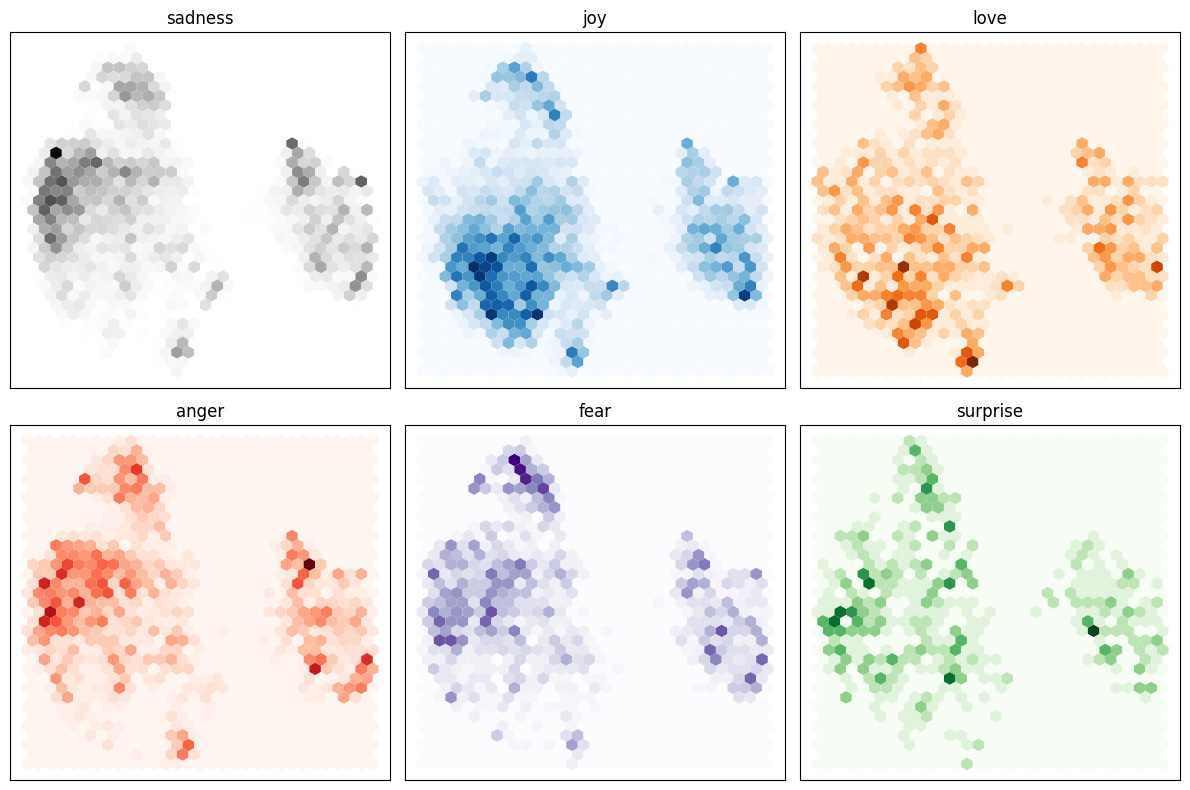

In [21]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=30, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [22]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [26]:
from huggingface_hub import notebook_login

notebook_login()

In [32]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [33]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Step,Training Loss,Validation Loss,Accuracy,F1
500,0.244800,0.186362,0.928000,0.928735
1000,0.129000,0.152386,0.938000,0.938072


In [34]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [35]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [38]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [39]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1509,i guess this is a memoir so it feels like that...,joy,fear,7.083722
1950,i as representative of everything thats wrong ...,surprise,sadness,7.032596
1963,i called myself pro life and voted for perry w...,joy,sadness,6.972498
1870,i guess i feel betrayed because i admired him ...,joy,sadness,6.719122
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.467929
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.930116
1111,im lazy my characters fall into categories of ...,joy,fear,5.320747
1590,deception from a person i loved very much,anger,love,5.153602
1964,i feel vaguely cheated and a little amused,joy,anger,5.113828
1683,i had applied for a job and they had assured m...,anger,joy,4.982854


In [40]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1619,i sat in the car and read my book which suited...,joy,joy,0.001685
876,i feel like the cool mom,joy,joy,0.001750
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.001768
1873,i feel practically virtuous this month i have ...,joy,joy,0.001776
723,i was able to go to a st party i am back feeli...,joy,joy,0.001776
1263,i feel this way about blake lively,joy,joy,0.001780
960,i feel that i am smart person who thinks about...,joy,joy,0.001782
1884,i don t exactly feel sociable still,joy,joy,0.001790
856,i feel is more energetic in urban singapore th...,joy,joy,0.001791
1418,i am a big believer in the phrase that some pe...,joy,joy,0.001795


In [41]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/jeremygf/distilbert-base-uncased-finetuned-emotion/commit/3408fc85802dcc15c8f65b4cae2e870e310a2dd4', commit_message='Training completed!', commit_description='', oid='3408fc85802dcc15c8f65b4cae2e870e310a2dd4', pr_url=None, pr_revision=None, pr_num=None)

In [42]:
from transformers import pipeline

model_id = "jeremygf/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [43]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/home/jeremygf/git/ml-notebooks/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


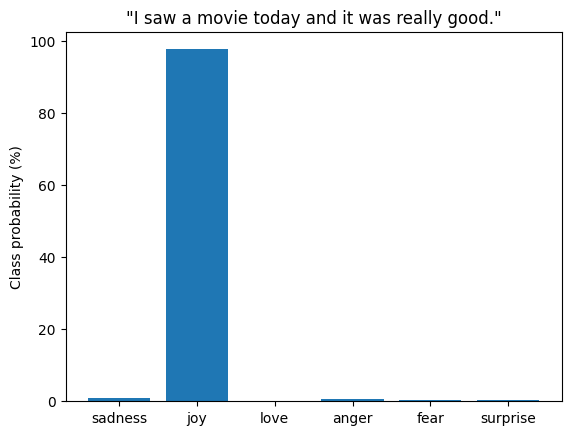

In [44]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()
